**File name**: main.ipynb<br>
**Author**: Anton Karazeev &lt;[anton.karazeev@gmail.com](mailto:anton.karazeev@gmail.com)&gt;<br>
This file is part of REDE project (https://github.com/akarazeev/REDE)

In [60]:
from utils.dataset import REDE
import torch
import torchvision
import torchvision.transforms as transforms

train_dataset = REDE('data/rede', train=True, transform=torchvision.transforms.ToTensor(),
                     download=True, test_size=0.2)
train_dataset

Dataset REDE
    Number of datapoints: 844
    Split: train (test_size: 0.2)
    Root Location: data/rede
    Transforms (if any): <torchvision.transforms.ToTensor object at 0x114fcbd30>

In [61]:
test_dataset = REDE('data/rede', train=False, transform=torchvision.transforms.ToTensor(),
                   download=True, test_size=0.2, test_indices=train_dataset.test_indices)
test_dataset

Dataset REDE
    Number of datapoints: 212
    Split: test (test_size: 0.2)
    Root Location: data/rede
    Transforms (if any): <torchvision.transforms.ToTensor object at 0x115223470>

In [62]:
BATCH = 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH)

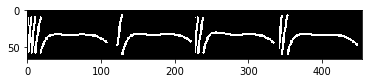

In [63]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Function to show an image.
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, parameters = dataiter.next()

# Show images.
imshow(torchvision.utils.make_grid(images))

In [64]:
# Corresponding parameters of simulated models -
# (gap, width1, height, radius1, width2).
parameters


1.00000e-05 *
  0.0300  0.1450  0.0750  2.4000  0.0880
  0.0350  0.1450  0.0750  2.0000  0.0840
  0.0300  0.1550  0.0850  2.4000  0.0920
  0.0350  0.1500  0.0700  2.2000  0.0920
[torch.FloatTensor of size 4x5]

In [65]:
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 3, 5, stride=2),
            nn.MaxPool2d(5, 1),
            nn.Conv2d(3, 5, 3, stride=1),
            nn.MaxPool2d(3, 1),
            nn.ReLU(True),
            nn.Conv2d(5, 2, 3, stride=1),
            nn.MaxPool2d(2, 2)
        )
        self.head = nn.Linear(396, 5)

    def forward(self, x):
        x = self.encoder(x)
        return self.head(x.view(x.size(0), -1))

criterion = nn.MSELoss()

# Train

In [66]:
def test_net(net):
    """Function helps to calculate loss on test dataset."""
    test_loss = 0
    for data in test_loader:
        
        inputs, labels = data
        labels = labels * 1e7

        inputs, labels = Variable(inputs), Variable(labels)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.data[0]
    return test_loss

# Training loop

In [67]:
%%time

EPOCH = 10  # Total number of epochs to train.
LR = 0.0001  # Initial learning rate.

net = Net()
optimizer = optim.Adam(net.parameters(), LR)

print_each = 30  # Print training loss every `print_each` iteration.
test_each = 2    # Print testing loss every `test_each` epoch.
reduce_lr = 4    # Reduce `LR` by 2 every `reduce_lr` epoch.

curtimestep = 0
test_steps = []
test_losses = []
train_steps = []
train_losses = []

for epoch in range(EPOCH):  # Loop over the dataset multiple times.
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        for param_group in optimizer.param_groups:
            param_group['lr'] = LR
        
        # Get the inputs.
        inputs, parameters = data
        parameters = parameters * 1e7

        # Wrap them in Variable.
        inputs, parameters = Variable(inputs), Variable(parameters)

        # Zero the parameter gradients.
        optimizer.zero_grad()

        # Forward -> backward -> optimize.
        outputs = net(inputs)
        loss = criterion(outputs, parameters)
        loss.backward()
        optimizer.step()
        
        # Add loss per element.
        running_loss += loss.data[0] / len(parameters)
        
        curtimestep += 1
        
        # Print statistics.
        if i % print_each == print_each - 1:
            loss_per_element = running_loss / print_each
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, loss_per_element))
            
            train_losses.append(loss_per_element)
            train_steps.append(curtimestep)
            running_loss = 0.0

    # Calculate loss on test dataset.
    if epoch % test_each == test_each - 1:
        test_loss = test_net(net)
        test_loss /= len(test_dataset)
        print('[%d] Test loss: %.3f' % (epoch + 1, test_loss))
        print('LR: {}'.format(LR))
        
        test_losses.append(test_loss)
        test_steps.append(curtimestep)
    
    # Reduce LR by 2 every `reduce_lr` epoch.
    if epoch % reduce_lr == reduce_lr - 1:
        LR /= 2.

print('Finished Training')

[1,    30] loss: 2184.472
[1,    60] loss: 2245.866
[1,    90] loss: 2299.113
[1,   120] loss: 2163.322
[1,   150] loss: 2107.625
[1,   180] loss: 2090.385
[1,   210] loss: 2079.091
[2,    30] loss: 1865.889
[2,    60] loss: 1772.638
[2,    90] loss: 1614.071
[2,   120] loss: 1258.339
[2,   150] loss: 925.053
[2,   180] loss: 620.285
[2,   210] loss: 367.823
[2] Test loss: 222.664
LR: 0.0001
[3,    30] loss: 126.305
[3,    60] loss: 51.488
[3,    90] loss: 28.105
[3,   120] loss: 18.441
[3,   150] loss: 16.536
[3,   180] loss: 14.027
[3,   210] loss: 20.823
[4,    30] loss: 13.185
[4,    60] loss: 16.981
[4,    90] loss: 19.006
[4,   120] loss: 18.033
[4,   150] loss: 16.558
[4,   180] loss: 13.921
[4,   210] loss: 20.734
[4] Test loss: 17.053
LR: 0.0001
[5,    30] loss: 13.175
[5,    60] loss: 16.854
[5,    90] loss: 18.924
[5,   120] loss: 17.873
[5,   150] loss: 16.454
[5,   180] loss: 13.855
[5,   210] loss: 20.540
[6,    30] loss: 12.960
[6,    60] loss: 16.825
[6,    90] loss: 18

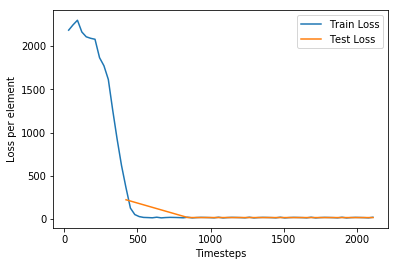

In [68]:
plt.plot(train_steps, train_losses, label='Train Loss')
plt.plot(test_steps, test_losses, label='Test Loss')
plt.xlabel('Timesteps')
plt.ylabel('Loss per element')
plt.legend()
plt.show()

# Test

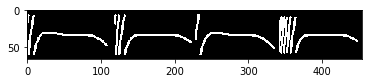

In [69]:
# Get some random testing images.
dataiter = iter(test_loader)
images, parameters = dataiter.next()

# Print images.
imshow(torchvision.utils.make_grid(images))

In [70]:
parameters * 1e7


   3.5000   14.5000    7.5000  220.0000    9.6000
   3.5000   14.5000    7.0000  220.0000    8.4000
   2.5000   15.5000    8.5000  180.0000    9.6000
   3.5000   14.5000    7.0000  240.0000    8.0000
[torch.FloatTensor of size 4x5]

In [71]:
inputs = Variable(images)
outputs = net(inputs)
outputs

Variable containing:
   3.0860   15.1973    7.9948  203.0638    9.0448
   3.1034   14.2126    7.1254  216.7515    8.1921
   3.1021   15.1499    7.9927  205.5840    9.5847
   2.9889   14.5334    7.3835  232.8750    7.6512
[torch.FloatTensor of size 4x5]